In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import files
uploaded = files.upload()

Saving financial_goal_data.csv to financial_goal_data.csv


In [3]:
filepath = 'financial_goal_data.csv'
dataset = pd.read_csv(filepath)
dataset.head()

,income,expenses_listrik,expenses_transport,expenses_makanan,goal_amount,goal_duration,remaining_time,goal_achievable,current_savings
0,10000000,1000000,1000000,2500000,20000000,9,8,1,1800000
1,12000000,800000,500000,3000000,30000000,3,2,0,5700000
2,8000000,700000,600000,1500000,20000000,9,7,1,2900000
3,12000000,500000,1200000,2500000,10000000,9,8,1,3500000
4,12000000,700000,800000,1500000,25000000,12,12,1,900000


In [4]:
def create_training_data(filepath):
  #read csv file
  dataset = pd.read_csv("financial_goal_data.csv")

  # Pastikan goal_duration tidak nol
  dataset = dataset[dataset['goal_duration'] > 0]

  #add monthly_target_savings as new feature
  dataset['monthly_target_savings'] = (dataset['goal_amount'] - dataset['current_savings']) / dataset['goal_duration']

  #define feature and target
  features = dataset[['goal_amount', 'goal_duration', 'current_savings']].values
  targets = dataset['monthly_target_savings']

  return features, targets

In [5]:
#generate training data
X, y = create_training_data(filepath)
print('Features X : ', X[:5])
print('\nTargets Y : ', y[:5])
print(f'\nFeatures X shape : {X.shape}')
print(f'\nTargets Y shape : {y.shape}')

Features X :  [[20000000        9  1800000]
 [30000000        3  5700000]
 [20000000        9  2900000]
 [10000000        9  3500000]
 [25000000       12   900000]]

Targets Y :  0    2.022222e+06
1    8.100000e+06
2    1.900000e+06
3    7.222222e+05
4    2.008333e+06
Name: monthly_target_savings, dtype: float64

Features X shape : (10000, 3)

Targets Y shape : (10000,)


In [6]:
#split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#normalize the features
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [8]:
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))

In [9]:
def define_and_compile_model():
  #define DNN model
  model = tf.keras.Sequential([
      #input layers with number of features
      tf.keras.layers.InputLayer(input_shape=(3,)),
      #hidden layers
      tf.keras.layers.Dense(units=64, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=16, activation='relu'),
      #output layer
      tf.keras.layers.Dense(units=1, activation='linear') #predict monthly savings target
  ])

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.01,
      decay_steps=1000,
      decay_rate=0.9
  )
  #compile model
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=['mae']
  )

  return model

In [10]:
#defining the callback
class EarlyStopCallback(tf.keras.callbacks.Callback):
  def __init__(self, monitor='mae', threshold=1.1612e-04, patience=50):
    super(EarlyStopCallback, self).__init__()
    self.monitor = monitor
    self.threshold = threshold
    self.patience = patience
    self.wait = 0
    self.best_loss = float('inf')

  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get(self.monitor)
    if current_loss is not None:
      if current_loss < self.best_loss:
        self.best_loss = current_loss
        self.wait = 0
      else:
        self.wait += 1

      if self.best_loss <= self.threshold:
        print(f"\nReached target {self.monitor} <= {self.threshold:.0f} at epoch {epoch+1}, stopping training")
        self.model.stop_training = True
      elif self.wait >= self.patience:
        print(f"\nNo improvement in {self.monitor} for {self.patience} consecutive epochs. Stopping Training")
        self.model.stop_training = True

In [11]:
model = define_and_compile_model()
training_history = model.fit(
    X_train, y_train,
    epochs = 500,
    batch_size = 32,
    validation_split = 0.2,
    callbacks = [EarlyStopCallback()]
)

loss, mae = model.evaluate(X_test, y_test)
print('Test MAE : ', mae)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0089 - mae: 0.0421 - val_loss: 1.1281e-05 - val_mae: 0.0024
Epoch 2/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.5113e-05 - mae: 0.0039 - val_loss: 4.1796e-05 - val_mae: 0.0057
Epoch 3/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8370e-05 - mae: 0.0037 - val_loss: 5.2916e-05 - val_mae: 0.0065
Epoch 4/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3521e-05 - mae: 0.0026 - val_loss: 2.1793e-06 - val_mae: 0.0012
Epoch 5/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6255e-06 - mae: 0.0012 - val_loss: 1.6915e-06 - val_mae: 0.0010
Epoch 6/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.0180e-06 - mae: 0.0017 - val_loss: 1.1068e-06 - val_mae: 8.0965e-04
Epoch 7/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6426e-04 - mae: 0.0046 - val_loss: 1.2166e-05 - val_mae: 0.0027
Epoch 8/500
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3127e-05 - mae: 0.0042 - val_loss: 4.3901e-06 - val_mae: 0.0

In [12]:
y_pred = model.predict(X_test)
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)
from sklearn.metrics import mean_absolute_error
mae_original = mean_absolute_error(y_test_original, y_pred_original)
print('Test MAE (Original Scale):', mae_original)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MAE (Original Scale): 2747.001557899165


In [13]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,644 (33.77 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,763 (22.52 KB)

None


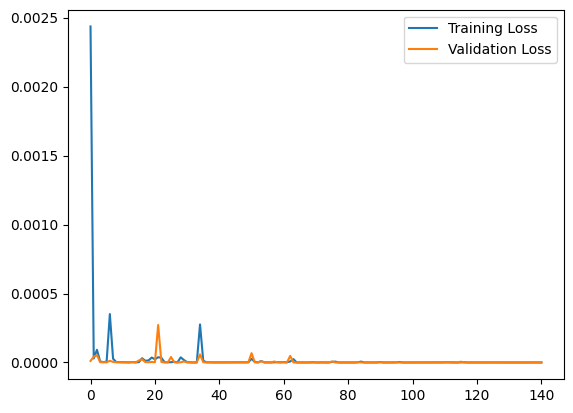

In [14]:
import matplotlib.pyplot as plt

plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


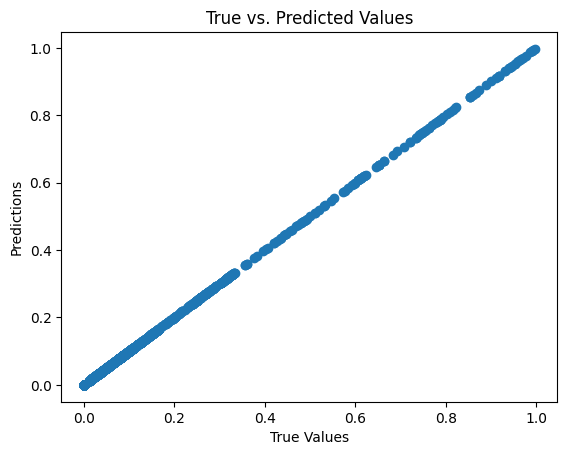

In [15]:
import matplotlib.pyplot as plt

predictions = model.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

In [16]:
import math
def rounded_up_to_nearest(vale, base = 100000):
  return math.ceil(vale / base) * base

def format_currency(value):
  return f'Rp{value:,.0f}'.replace(',', '.')

In [17]:
# Contoh data baru
new_data = {
    'goal_amount': 20000000,  # goal_amount
    'goal_duration': 5,  # goal_duration
    'current_savings': 5000000  # current_savings
}

# Siapkan array dengan semua fitur
new_data_array = np.array([
    new_data['goal_amount'],
    new_data['goal_duration'],
    new_data['current_savings']
]).reshape(1, -1)

# Normalisasi data
new_data_normalized = scaler_X.transform(new_data_array)

# Prediksi
predicted_normalized = model.predict(new_data_normalized)
predicted_original = scaler_y.inverse_transform(predicted_normalized)
predicted_roundedup = rounded_up_to_nearest(predicted_original[0][0])
predicted_formatted = format_currency(predicted_roundedup)

print("Dengan melihat tujuan keuangan anda, kami merekomendasikan anda untuk menyisihkan\nsebesar", predicted_formatted, "setiap bulannya.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Dengan melihat tujuan keuangan anda, kami merekomendasikan anda untuk menyisihkan
sebesar Rp3.100.000 setiap bulannya.


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Prediksi pada data uji
y_pred_normalized = model.predict(X_test)

# De-normalisasi prediksi dan target
y_pred = scaler_y.inverse_transform(y_pred_normalized)
y_true = scaler_y.inverse_transform(y_test)

# Hitung MAE
mae = mean_absolute_error(y_true, y_pred)

# Hitung MSE
mse = mean_squared_error(y_true, y_pred)

# Hitung RMSE
rmse = np.sqrt(mse)

# Hitung R²
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error (MAE): 2747.00
Mean Squared Error (MSE): 17998565.58
Root Mean Squared Error (RMSE): 4242.47
R-squared (R²): 1.00


In [ ]:
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
model.save('financial_goal_model.h5', include_optimizer=True)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('financial_goal_model.h5')
print(model.summary())  # Untuk memverifikasi bahwa model memuat dengan benar

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,882 (11.26 KB)

 Trainable params: 2,881 (11.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1 (8.00 B)

None


In [ ]:
!pip install tensorflowjs --no-cache-dir

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 192.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 182.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 177.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 254.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 201.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 211.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfu

In [ ]:
!tensorflowjs_converter --input_format keras \
--output_format tfjs_layers_model \
financial_goal_model.h5 \
tfjs_model

2024-12-07 20:45:59.106679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733604359.177642    3965 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733604359.218565    3965 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 20:45:59.352295: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed

In [ ]:
!zip -r tfjs_model.zip tfjs_model

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 80%)
  adding: tfjs_model/group1-shard1of1.bin (deflated 7%)
